In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import operator
%matplotlib inline

from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

---
#Using PCA to 'optimize' the brute force solution
---

---
##Do a little data munging
---

In [3]:
df = pd.read_csv('/Users/mrgholt/GADS-22-NYC/Datasets/Hitters.csv')
df.dropna(inplace = True)
df.League = pd.factorize(df.League)[0]
df.Division = pd.factorize(df.Division)[0]
df.NewLeague = pd.factorize(df.NewLeague)[0]

---
##Feature Scale
---

In [6]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

---
##From the brute force solution take the best predictors that were found
---

In [7]:
best_predictors = ['AtBat', 'Walks', 'Years', 'CRBI', 'NewLeague']

---
## Now see if we can trim the input dimension using PCA, while retaining predictive performance
---

In [8]:
#a 50/50 split of the training and test data
X_train, X_test, y_train, y_test = train_test_split(df_scaled[best_predictors], \
                        df_scaled['Salary'], test_size=0.5, random_state=42)

#we know the optimal polynomial degree
pf_model = PolynomialFeatures(4).fit(X_train)
pf = pf_model.transform(X_train)

#accumulate the mse's in this list
mse_list = []

#we want to reduce the input dimension below 126 (we found 126 from brute force)
for n in xrange(1, 127):

    myPCA = PCA(n_components = n).fit(pf)
    X_transform = myPCA.transform(pf)
    
    #use the value of alpha from brute force, although we might want to re-evaluate this if we choose a lower
    #input dimension
    clfR = Ridge(alpha = 7.74263682681)
    clfR.fit(X_transform, y_train)

    #prepare the test set for use in the model
    pf_X_test = pf_model.transform(X_test)
    X_test_transform = myPCA.transform(pf_X_test)

    #predict 
    yhat = clfR.predict(X_test_transform)
    
    #evaluate the mse
    mse = mean_squared_error(yhat, y_test)
    mse_list.append(mse)

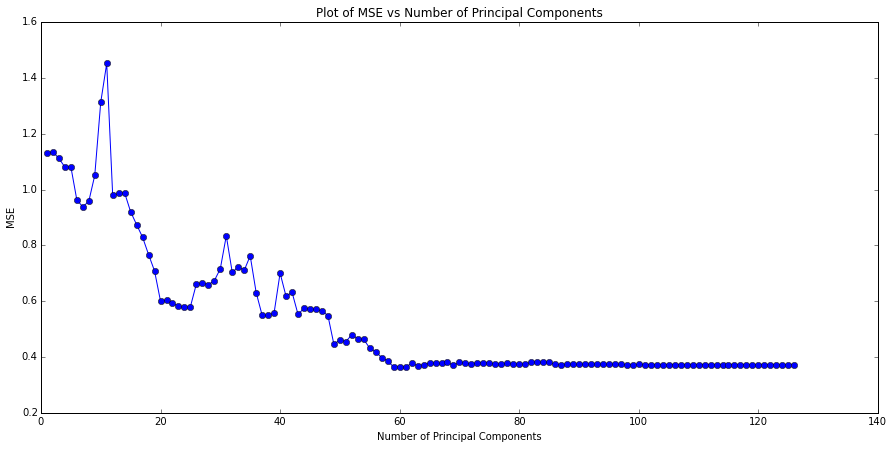

In [9]:
#Now plot the mse against the number of principal components

x_plot = xrange(1, 127)
fig = plt.figure(figsize = (15, 7))
ax = plt.subplot(111)
ax.plot(x_plot, mse_list, marker = 'o', color = 'b')
ax.set_title("Plot of MSE vs Number of Principal Components")
ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("MSE")

In [10]:
#somewhere between 50 and 70 looks a good choice

ma = np.array(mse_list[50:70])
print "Minimum is {:8.5f}".format(ma.min())
print "Index is {:d}".format(50 + ma.argmin())

Minimum is  0.36403
Index is 58


In [12]:
#reconfirm the model using all the now-known values

X_train, X_test, y_train, y_test = train_test_split(df_scaled[best_predictors], \
                        df_scaled['Salary'], test_size=0.5, random_state=42)

#degree 4 polynomial
pf_model = PolynomialFeatures(4).fit(X_train)
pf = pf_model.transform(X_train)

#a 58 input dimension - still pretty big!!
myPCA = PCA(n_components = 58).fit(pf)
X_transform = myPCA.transform(pf)

#use Ridge
clfR = Ridge(alpha = 7.74263682681)
clfR.fit(X_transform, y_train)

#test
pf_X_test = pf_model.transform(X_test)
X_test_transform = myPCA.transform(pf_X_test)
yhat = clfR.predict(X_test_transform)

#print the mse - NB: this is the mse on the validation set really
mse = mean_squared_error(yhat, y_test)
print "Final mse is {:7.5f}".format(mse)

Final mse is 0.38585
